# Import Libraries

In [270]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
from numpy import asarray
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.regularizers import l2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Model

from tensorflow.keras.applications import EfficientNetB0, VGG16, VGG19, ResNet50, InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers

import random

# Set a random seed.
np.random.seed(42)

In [2]:
##install cv2
#pip install opencv-python-headless
#pip install opencv-contrib-python-headless
import os
import cv2

------------------------------------------------------------------------------------------------------------------------------------------------

# Input Dataset

**Input filepaths are set depending if the notebook is run on google colab or local machine. Modeling was carried on Google Colab for speed**

In [72]:
try:
    from google.colab import drive
    model_dir = Path('/content/drive/My Drive/Colab_Notebooks/state_farm/models') # for colab
    train_img_dir = '/content/drive/My Drive/Colab_Notebooks/state_farm/data/imgs/train'
    test_img_dir = Path('/content/drive/My Drive/Colab_Notebooks/state_farm/data/imgs/test')
    csv_dir = '/content/drive/My Drive/Colab_Notebooks/state_farm/data/csv'
    csv_file = 'driver_imgs_list.csv'
    submissions_dir = '/content/drive/My Drive/Colab_Notebooks/state_farm/submissions'
    code_in = 'Google Colab'
    drive.mount('/content/drive')
except:
    model_dir = Path('../models') # for local machine
    train_img_dir = '../data/imgs/train'
    test_img_dir = Path('../data/imgs/test')
    csv_dir = '../data/csv'
    csv_file = 'driver_imgs_list.csv'
    submissions_dir = '../submissions'
    code_in = 'Local Machine'

print(f'Code is run from {code_in}')

Code is run from Local Machine


In [13]:
# train_img_dir = '../data/imgs/train'
# test_img_dir = Path('../data/imgs/test')
# csv_dir = '../data/csv'
# csv_file = 'driver_imgs_list.csv'

**All the labels to classify the images and their corresponding description**

In [14]:
class_labels_dict = {'c0' : 'safe driving',
'c1' : 'texting - right',
'c2' : 'talking on the phone - right',
'c3' : 'texting - left',
'c4' : 'talking on the phone - left',
'c5' : 'operating the radio',
'c6' : 'drinking',
'c7' : 'reaching behind',
'c8' : 'hair and makeup',
'c9' : 'talking to passenger'}

------------------------------------------------------------------------------------------------------------------------------------------------

# Test Images Dataset

In [15]:
test_images_files = list(test_img_dir.glob(r'**/*.jpg'))

In [16]:
test_df = pd.DataFrame(test_images_files).astype(str)

In [17]:
test_df.columns=['filepaths']

In [18]:
test_df

filepaths
0      ../data/imgs/test/img_60161.jpg
1      ../data/imgs/test/img_94786.jpg
2      ../data/imgs/test/img_85853.jpg
3      ../data/imgs/test/img_36327.jpg
4      ../data/imgs/test/img_39014.jpg
...                                ...
79721  ../data/imgs/test/img_77404.jpg
79722  ../data/imgs/test/img_68524.jpg
79723  ../data/imgs/test/img_67617.jpg
79724  ../data/imgs/test/img_30997.jpg
79725  ../data/imgs/test/img_21642.jpg

[79726 rows x 1 columns]

# EDA

**Reading the train csv**

In [19]:
# df = pd.read_csv ("../data/csv/driver_imgs_list.csv")
csv = pd.read_csv(os.path.join(csv_dir, csv_file))
csv['filepaths'] = csv.apply(lambda x: os.path.join(train_img_dir, x['classname'], x['img']), axis=1)

In [20]:
csv.head(2)

subject classname            img                            filepaths
0    p002        c0  img_44733.jpg  ../data/imgs/train/c0/img_44733.jpg
1    p002        c0  img_72999.jpg  ../data/imgs/train/c0/img_72999.jpg

In [21]:
csv.shape

(22424, 4)

**Count of Subject and Class Labels**

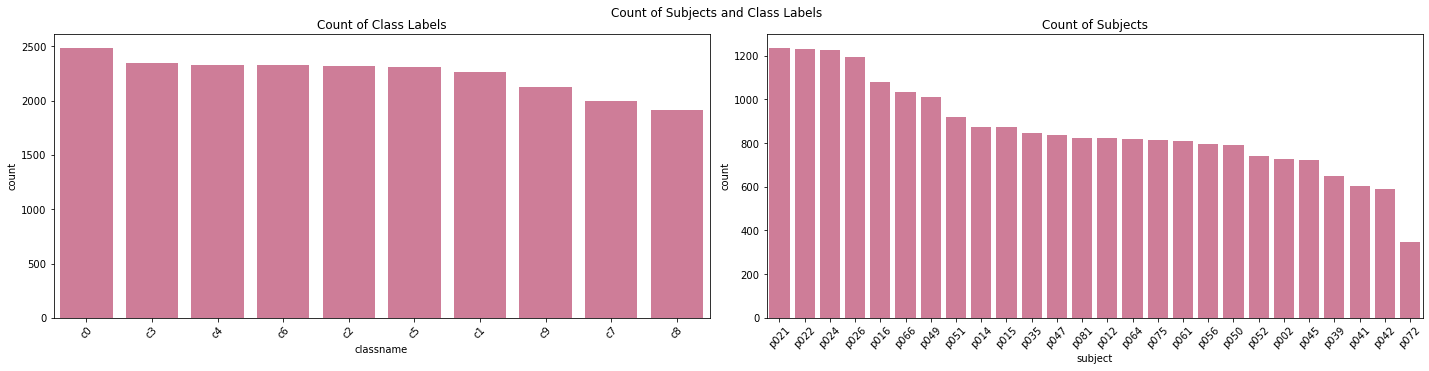

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.countplot(data=csv, x='classname', orient='h', ax=ax1, color='palevioletred', order = csv['classname'].value_counts().index)
sns.countplot(data=csv, x='subject', orient='h', ax=ax2, color='palevioletred', order = csv['subject'].value_counts().index)
fig.suptitle('Count of Subjects and Class Labels')
plt.tight_layout()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45)
ax1.set_title('Count of Class Labels')
ax2.set_title('Count of Subjects');


In [23]:
# Count of subjects
csv['subject'].nunique()

26

**There are 26 different subjects in the train+test dataset**

**Verifying if all the class labels are present for all the subjects**

In [24]:
#checking if all subjects have images with 10 class labels
csv.groupby(['subject'])['classname'].nunique()

subject
p002    10
p012    10
p014    10
p015    10
p016    10
p021    10
p022    10
p024    10
p026    10
p035    10
p039    10
p041    10
p042    10
p045    10
p047    10
p049    10
p050    10
p051    10
p052    10
p056    10
p061    10
p064    10
p066    10
p072    10
p075    10
p081    10
Name: classname, dtype: int64

**Distribution of each class within a subject**

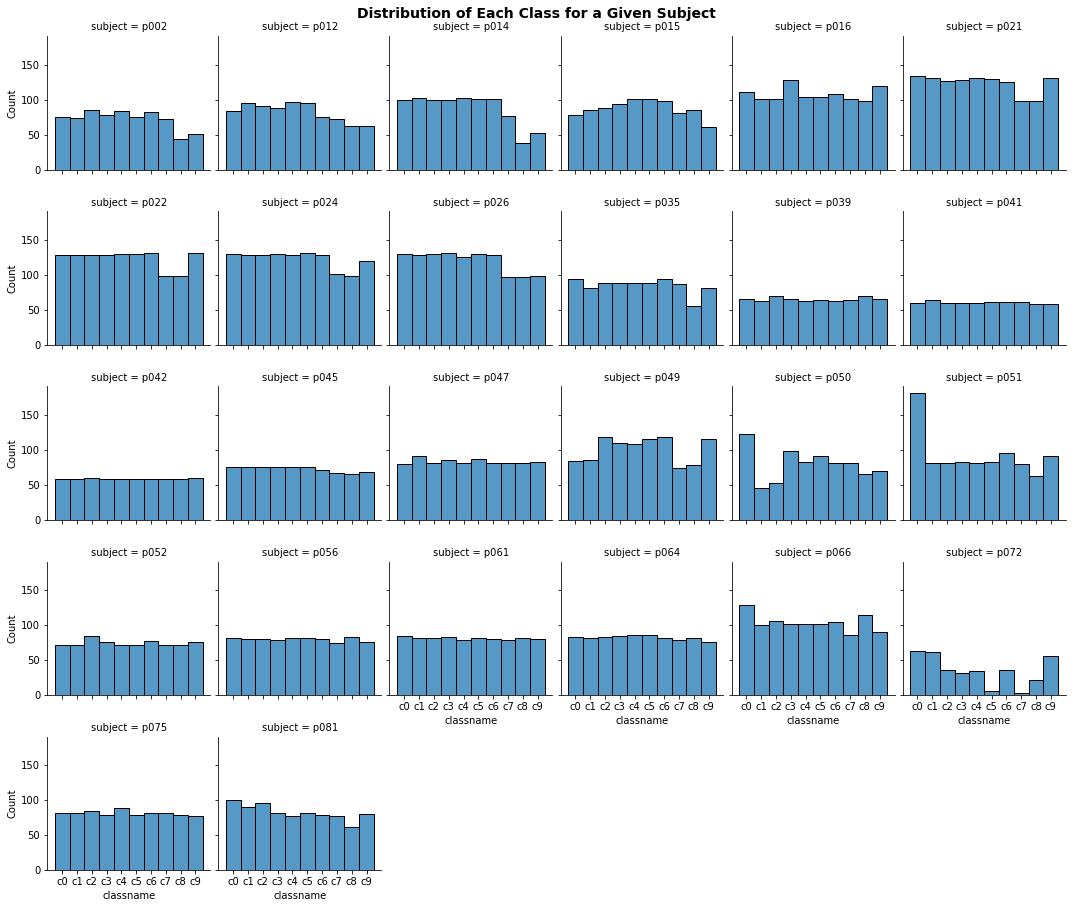

In [25]:
g = sns.displot(data=csv, x='classname', col='subject', col_wrap=6, height=2.5)
g.tight_layout()
g.fig.subplots_adjust(wspace=0.05)
g.fig.suptitle('Distribution of Each Class for a Given Subject', 
                fontsize=14, fontweight='extra bold', y=1.005);

**Most of the subjects have uniform distribution of class labels. Subject 072 has the unbalanced distribution for c5 and c7 and in general the number of images are lower as compared to the other subjects. Subject 051 has skewed distribution of c0 labels**

**Visualizing all the class labels**

**Visualizing the poses of the subject associated with individual class labels**

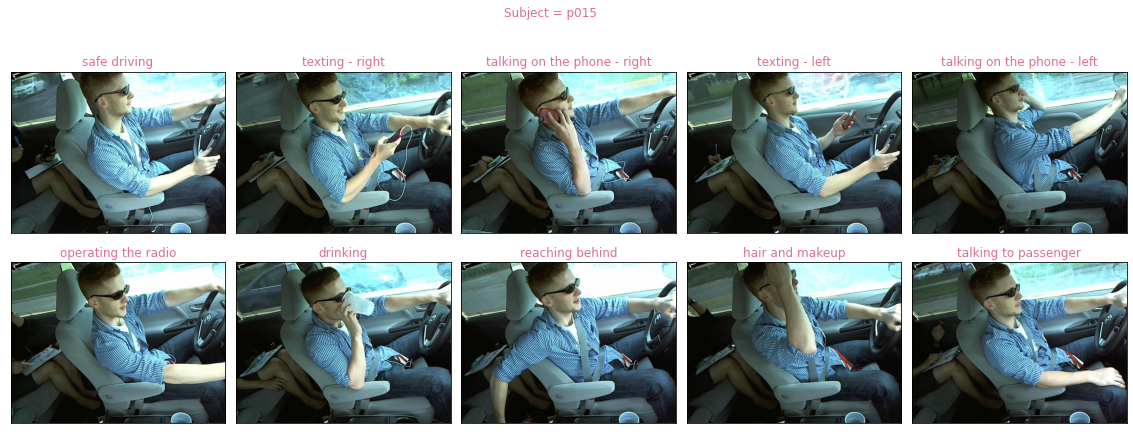

In [26]:
class_labels = sorted(list(set(csv['classname'].values)))
subject_labels = sorted(list(set(csv['subject'].values)))
subject_idx = 3 #specific subject to plot
f,a = plt.subplots(nrows=2, ncols=5,figsize=(20, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    lbl = class_labels[i]
    lbl_df = csv[csv['subject']==subject_labels[subject_idx ]].reset_index()
    lbl_file = lbl_df.loc[(lbl_df['classname'].values==lbl).argmax(), 'filepaths']
    # lbl_file = csv.loc[(csv['classname'].values==lbl).argmax(), 'filepaths']
    ax.imshow(plt.imread(lbl_file))
    ax.set_title(class_labels_dict[lbl], color='palevioletred')
    # ax.imshow(plt.imread(df.filepaths[i]))
    # ax.set_title(df.labels[i])
    
# plt.tight_layout()
f.suptitle(f'Subject = {subject_labels[subject_idx]}', color='palevioletred')
plt.subplots_adjust(hspace=0.0, wspace=0.05)
plt.show()

**Visualizing all the subjects**

**A sample collection of all subjects while talking on the phone with their right hand**

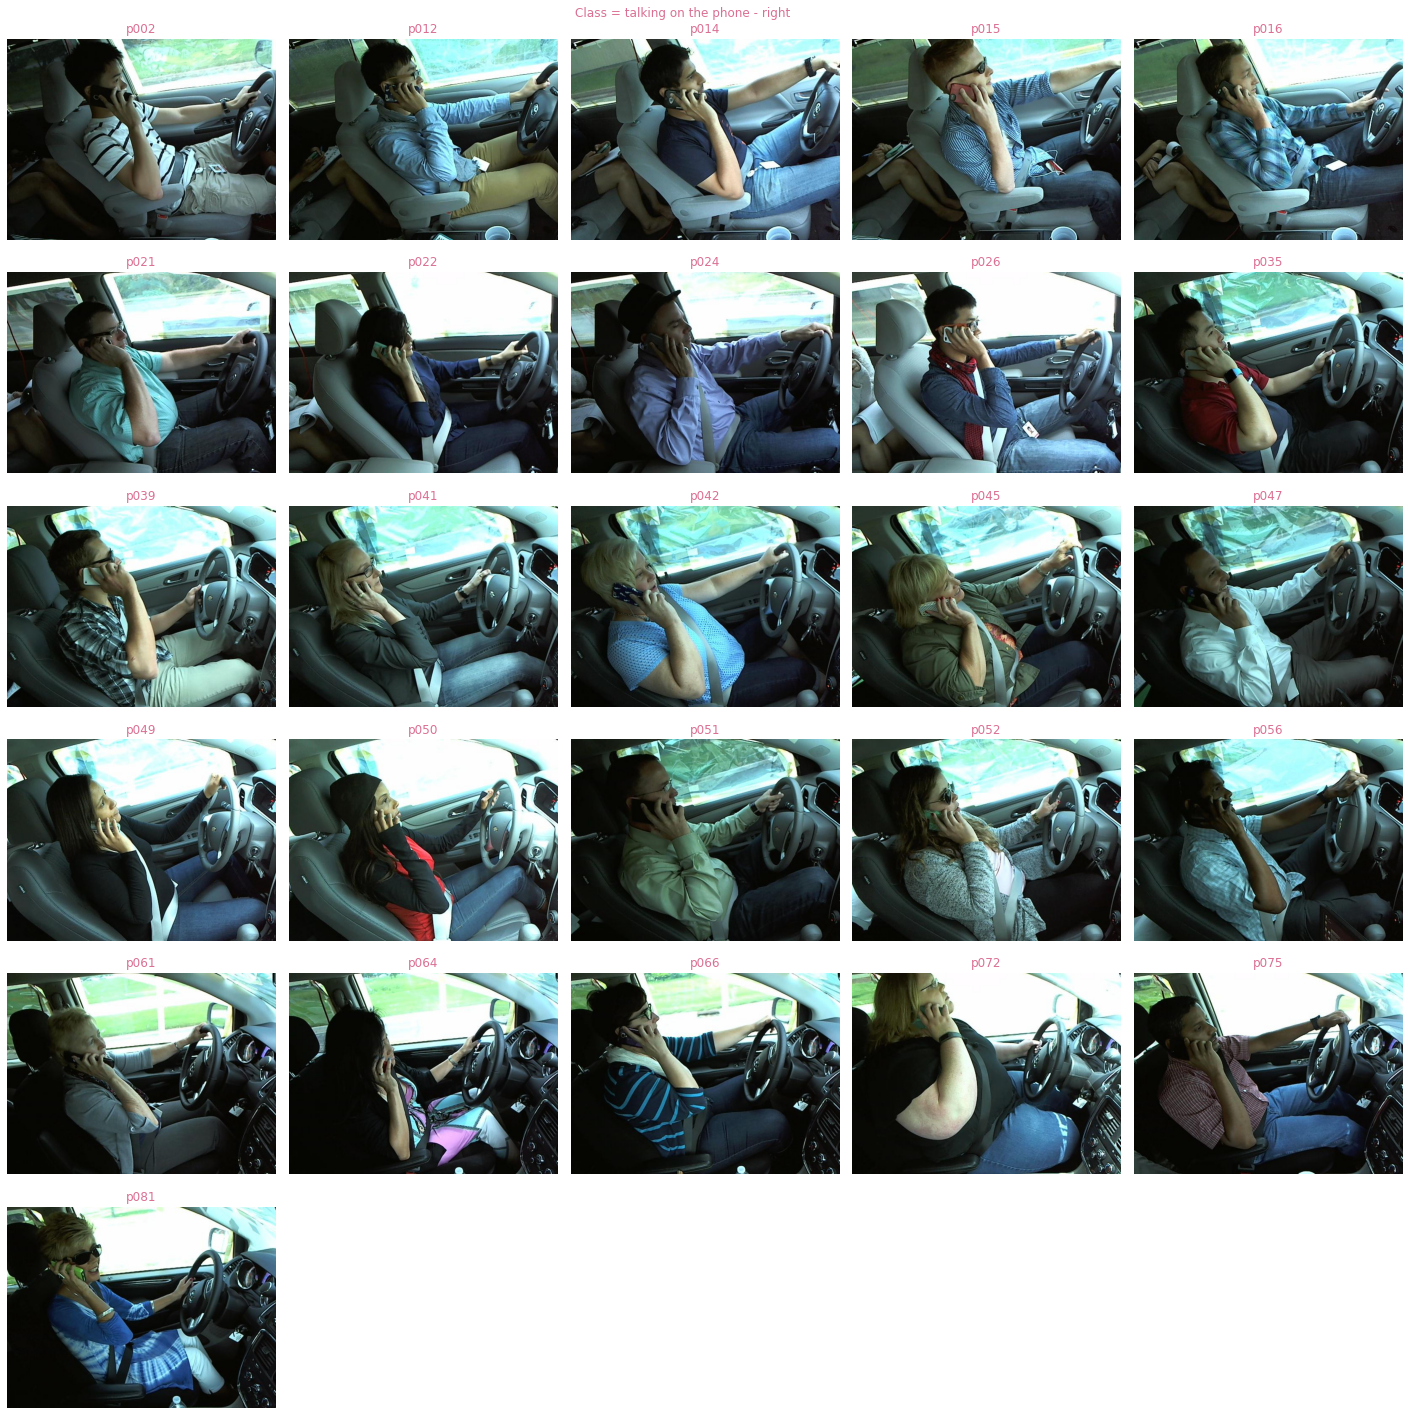

In [301]:
class_idx = 2 # set this based on what class is to be displayed for all subjects
class_labels = sorted(list(set(csv['classname'].values)))
subject_labels = sorted(list(set(csv['subject'].values)))

fig = plt.figure(figsize=(25,23))

for i in range(len(subject_labels)):
    ax = fig.add_subplot(6,5,i+1)
    lbl = subject_labels[i]
    lbl_df = csv[csv['classname']==class_labels[class_idx]].reset_index()
    lbl_file = lbl_df.loc[(lbl_df['subject'].values==lbl).argmax(), 'filepaths']
    # lbl_file = csv.loc[(csv['classname'].values==lbl).argmax(), 'filepaths']
    ax.imshow(plt.imread(lbl_file))
    ax.set_title(f'{subject_labels[i]}', color='palevioletred')
    ax.axis('off')
    

fig.suptitle(f'Class = {class_labels_dict[class_labels[class_idx]]}', color='palevioletred')
plt.gcf().subplots_adjust(hspace=0.01, wspace=0.05, top=0.97)


**Checking if the image sizes are consistent**

In [28]:
# Verifying whether all the train test images are of the same size. This takes a long time to run
img_shape_list = []
for root, dirs, files in os.walk("../"):
    path = root.split(os.sep)
    folder = os.path.basename(root)
    for file in files:
        if file.endswith('.jpg'):
            height, width, channels = cv2.imread(os.path.join(root, file)).shape
            img_shape_list.append([height, width, channels])

img_shape_df = pd.DataFrame(data=img_shape_list, columns=['height', 'width', 'channels'])
img_shape_df

In [29]:
img_shape_df.value_counts()

In [30]:
img_shape_df = []

**All the test and train images are of the same shape**

------------------------------------------------------------------------------------------------------------------------------------------------

# Train-Test Split

**Since the testing dataset does not contain any subject which is present in the training dataset, GroupKFold is used train test(val) split. For the base cnn model, regular train test split is used for comparison purposes**

In [54]:
# generate train test split
x_train, x_test = train_test_split(csv, test_size=0.2)

In [220]:
# generate train test split while ensuring that any given subject is only part of train OR test dataset, NOT BOTH
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)
X = csv['img']
y = csv['classname']
groups = csv['subject']
for train_idx, val_idx in gkf.split(X, y, groups=groups):
    x_train = csv.loc[train_idx, :]
    x_val = csv.loc[val_idx, :]
    print(x_train.shape, x_val.shape)
    print(x_train['subject'].unique(), x_val['subject'].unique())

(18017, 4) (4407, 4)
['p002' 'p012' 'p014' 'p016' 'p022' 'p024' 'p026' 'p035' 'p041' 'p042'
 'p045' 'p049' 'p050' 'p051' 'p052' 'p056' 'p064' 'p066' 'p072' 'p075'
 'p081'] ['p015' 'p021' 'p039' 'p047' 'p061']
(17949, 4) (4475, 4)
['p002' 'p012' 'p015' 'p016' 'p021' 'p024' 'p026' 'p039' 'p041' 'p042'
 'p047' 'p049' 'p050' 'p051' 'p052' 'p061' 'p064' 'p066' 'p072' 'p075'
 'p081'] ['p014' 'p022' 'p035' 'p045' 'p056']
(18060, 4) (4364, 4)
['p002' 'p012' 'p014' 'p015' 'p016' 'p021' 'p022' 'p026' 'p035' 'p039'
 'p042' 'p045' 'p047' 'p049' 'p052' 'p056' 'p061' 'p064' 'p066' 'p072'
 'p075'] ['p024' 'p041' 'p050' 'p051' 'p081']
(17720, 4) (4704, 4)
['p002' 'p012' 'p014' 'p015' 'p016' 'p021' 'p022' 'p024' 'p035' 'p039'
 'p041' 'p045' 'p047' 'p050' 'p051' 'p056' 'p061' 'p066' 'p075' 'p081'] ['p026' 'p042' 'p049' 'p052' 'p064' 'p072']
(17950, 4) (4474, 4)
['p014' 'p015' 'p021' 'p022' 'p024' 'p026' 'p035' 'p039' 'p041' 'p042'
 'p045' 'p047' 'p049' 'p050' 'p051' 'p052' 'p056' 'p061' 'p064' 'p072'
 '

## Image Augmentation

**Different models were evalulated and setting up the ImageAugmentation will vary from type of the architecture being evaluated**
- Base CNN Model just needs to be preprocessed by rescaling using the RESCALE=1./255
- VGG16, VGG19, EfficientNetB0 have their own preprocessing function inbuilt into keras. These pre-processing functions were appropriately selected before running the model. As such, this settings need to be changed depending on the model of interest

In [221]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2 
    #width_shift_range=0.3, #image augmentation parameters
    #height_shift_range=0.3,
    #shear_range=0.3,
    #zoom_range=0.4,
)

# train_generator.mean= [123.68, 116.779, 103.939]

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input,


)

# test_generator.mean= [123.68, 116.779, 103.939]

In [222]:
num_classes = 10
batch_size = 32

Training Dataset is split into train and validation dataset. For the testing dataset, images from the `test` folder were used. These images do not have a ground truth label associated with it. The only way to score the model on test dataset is to upload the model predictions to Kaggle which then scores it on log loss

In [223]:
train_images = train_generator.flow_from_dataframe(
    dataframe=x_train,
    x_col='filepaths',
    y_col='classname',
    target_size=(224, 224),
    rescale = 1./255,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

val_images = test_generator.flow_from_dataframe(
    dataframe=x_val,
    x_col='filepaths',
    y_col='classname',
    target_size=(224, 224),
    rescale = 1./255,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

# test_images = train_generator.flow_from_dataframe(
#     dataframe=x_test,
#     x_col='filepaths',
#     y_col='classname',
#     target_size=(224, 224),
#     rescale = 1./255,
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=batch_size,
#     shuffle=False
# )

Found 17950 validated image filenames belonging to 10 classes.
Found 4474 validated image filenames belonging to 10 classes.


In [224]:
val_images.class_indices

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

In [225]:
val_images.image_shape

(224, 224, 3)

------------------------------------------------------------------------------------------------------------------------------------------------

# Base Model

**Two Base models are generated**
- Regular train_test_split
- GroupKFold train_test_split

In [139]:
def base_model():
    cnn = Sequential()
    
    # Add a Input Layer - Convolutional layer.
    cnn.add(Conv2D(filters = 50,       #number of filters to use
                  kernel_size = (3, 3),   #dimensions of the filters
                  activation = 'relu',    #activation function
                  input_shape = (224, 224, 3)))  #shape of image
    
    # dimensions of region of pooling
    cnn.add(MaxPooling2D(pool_size = (2, 2)))   #filter dimensions
    
    #Convolutional layer
    cnn.add(Conv2D(16, kernel_size = (3, 3), activation = 'relu'))
    
    #pooling layer
    cnn.add(MaxPooling2D(pool_size = (2, 2)))
    
    #dense layers
    cnn.add(Flatten())
    # Add a densely-connected layer with 128 neurons.
    cnn.add(Dense(128, activation = 'relu'))
    # cnn.add(Dropout(0.2))
    cnn.add(Dense(64, activation = 'relu'))
    # cnn.add(Dropout(0.2))
    cnn.add(Dense(10, activation = 'softmax')) #add final layer with 10 nerous
    
    # Compile model
    cnn.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])
       
    return cnn

In [60]:
cnn = base_model()

checkpoint_callback = ModelCheckpoint('../models/base_model_kfold.hdf5', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=3)

#fit the model
history = cnn.fit(train_images,
                validation_data=val_images,
                epochs = 30,
                callbacks=[es, checkpoint_callback], verbose=1)

Epoch 1/30
561/561 [==============================] - 309s 550ms/step - loss: 0.5871 - accuracy: 0.8131 - val_loss: 0.0513 - val_accuracy: 0.9828
Epoch 2/30
561/561 [==============================] - 310s 552ms/step - loss: 0.0447 - accuracy: 0.9867 - val_loss: 0.0554 - val_accuracy: 0.9810
Epoch 3/30
561/561 [==============================] - 337s 601ms/step - loss: 0.0159 - accuracy: 0.9958 - val_loss: 0.0210 - val_accuracy: 0.9937
Epoch 4/30
561/561 [==============================] - 356s 634ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.0096 - val_accuracy: 0.9978
Epoch 5/30
561/561 [==============================] - 322s 573ms/step - loss: 0.0148 - accuracy: 0.9957 - val_loss: 0.0066 - val_accuracy: 0.9984
Epoch 6/30
561/561 [==============================] - 325s 579ms/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.0051 - val_accuracy: 0.9991
Epoch 7/30
128/561 [=====>........................] - ETA: 4:02 - loss: 6.6266e-04 - accuracy: 1.0000

KeyboardInterrupt: 

# VGG Model

VGG16 and VGG19 pretrained models with weights are used. CNN layers are freezed and they are not trained during the training process. Only the fully connected layers are set to trainable during the training phase. Multiple iterations of these 2 pre-trained models were carried by chaning the architecture of the fully connected layers. The parameters which were studied are:
- number of nodes in the hidden layers
- number of hidden layers
- learning rate of the ADAM optimizer
- regularization using dropout and l2

In [142]:
def vgg_model():
    # load model without classifier layers
    vgg_conv = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    # mark loaded layers as not trainable
    for layer in vgg_conv.layers:
        layer.trainable = False
    # add new classifier layers
    # Create the model
    model = Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0005)))
    #model.add(Dropout(0.2))
    # model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.0005)))
    #model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    #compile the model
    model.compile(tf.optimizers.Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [ ]:
def vgg19_model():
    # load model without classifier layers
    vgg_conv = VGG19(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    # mark loaded layers as not trainable
    for layer in vgg_conv.layers:
        layer.trainable = False
    # add new classifier layers
    # Create the model
    model = Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)))
    #model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.0005)))
    #model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    #compile the model
    model.compile(tf.optimizers.Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [148]:
model = vgg_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dense_20 (Dense)             (None, 10)                5130      
Total params: 27,565,386
Trainable params: 12,850,698
Non-trainable params: 14,714,688
_________________________________________________________________


**Model checkpoints are used to save the best model for each of the models being tested. Since only one epoch was getting saved, loss and accuracy plots against the epochs couldn't be analyzed**

In [149]:
checkpoint_callback = ModelCheckpoint('../models/best_model_vgg16_l2_512_adam_lr.hdf5', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs = 30,
                    callbacks=[es, checkpoint_callback], verbose=1)

Epoch 1/30
561/561 [==============================] - 2434s 4s/step - loss: 1.4660 - accuracy: 0.9296 - val_loss: 11.3386 - val_accuracy: 0.4761
Epoch 2/30
561/561 [==============================] - 2441s 4s/step - loss: 0.6027 - accuracy: 0.9838 - val_loss: 10.0416 - val_accuracy: 0.5769
Epoch 3/30
561/561 [==============================] - 2612s 5s/step - loss: 0.5030 - accuracy: 0.9919 - val_loss: 6.4736 - val_accuracy: 0.6743
Epoch 4/30
561/561 [==============================] - 2311s 4s/step - loss: 0.5204 - accuracy: 0.9921 - val_loss: 6.9353 - val_accuracy: 0.6931
Epoch 5/30
561/561 [==============================] - 2231s 4s/step - loss: 0.5812 - accuracy: 0.9883 - val_loss: 8.2721 - val_accuracy: 0.7005
Epoch 6/30
561/561 [==============================] - 2292s 4s/step - loss: 0.5029 - accuracy: 0.9934 - val_loss: 14.2305 - val_accuracy: 0.6334
Epoch 7/30
561/561 [==============================] - 2302s 4s/step - loss: 0.4490 - accuracy: 0.9956 - val_loss: 9.5909 - val_accura

------------------------------------------------------------------------------------------------------------------------------------------------

# EfficientNet Model

**The impact of ImageAugmentation was studied using the EfficientNetB0 pretrained model**

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator()

val_generator = tf.keras.preprocessing.image.ImageDataGenerator()

test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator_augment = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        #rescale=1./255,
        #shear_range=0.2,
        zoom_range=0.2,
        #horizontal_flip=True,
        fill_mode='nearest'
)
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#transfer-learning-from-pretrained-weights
def build_model(num_classes):
    #inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    #model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    
    model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    #model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    model = Model(inputs=model.inputs, outputs=outputs, name="EfficientNetB0")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
train_images_augmented = train_generator_augment.flow_from_dataframe(
    dataframe=x_train,
    x_col='filepaths',
    y_col='classname',
    target_size=(224, 224),
    #rescale = 1./255,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

val_images = val_generator.flow_from_dataframe(
    dataframe=x_val,
    x_col='filepaths',
    y_col='classname',
    target_size=(224, 224),
    #rescale = 1./255,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

train_images = train_generator.flow_from_dataframe(
    dataframe=x_train,
    x_col='filepaths',
    y_col='classname',
    target_size=(224, 224),
    #rescale = 1./255,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

val_images = val_generator.flow_from_dataframe(
    dataframe=x_val,
    x_col='filepaths',
    y_col='classname',
    target_size=(224, 224),
    #rescale = 1./255,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
model_v2_base = build_model(num_classes=10)
model_v2_base.summary();
checkpoint_callback = ModelCheckpoint('../models/best_model_EfficientNetB0_v2_base.hdf5', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=3)
history_EfficientNetB0_v2_base = model_v2_base.fit(train_images,
                    validation_data=val_images,
                    epochs = 20,
                    callbacks=[es, checkpoint_callback])

In [ ]:
model_v2_augment = build_model(num_classes=10)
model_v2_augment.summary()
checkpoint_callback = ModelCheckpoint('../models/best_model_EfficientNetB0_v2_augment.hdf5', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=3)
history_EfficientNetB0_v2_augment = model_v2_augment.fit(train_images_augmented,
                    validation_data=val_images,
                    epochs = 20,
                    callbacks=[es, checkpoint_callback])

------------------------------------------------------------------------------------------------------------------------------------------------

# Generating Evaluation Scores

**This section loops through all the models and generates the training and validation accuracy and loss values**

In [141]:
def eval_scores(train_images, val_images, eval_df, filename):
    # evaluate the model
    print(f'Evaluation Model = {filename}')
    print(f'Evaluating Training Dataset')
    train_scores = loaded_model.evaluate(train_images, verbose=1)
    
    print(f'Evaluating Validation Dataset')
    val_scores = loaded_model.evaluate(val_images, verbose=1)
    
    #print("Training Accuracy Score   = %.2f%%" % (train_scores[1]*100))
    #print("Validation Accuracy Score = %.2f%%" % (val_scores[1]*100))
    
    # eval_df.iloc[rowidx] = filename + train_scores + val_scores
    # ls_eval_scores = [filename] + train_scores + val_scores
    return train_scores, val_scores
    
    # return eval_df
    
    
    

In [150]:
models = list(model_dir.glob(r'**/*.hdf5'))
models

[PosixPath('../models/best_model_vgg16_dropout_1024.hdf5'),
 PosixPath('../models/best_model_vgg16_l2_1024.hdf5'),
 PosixPath('../models/best_model_vgg19_l2_4096_1024_adam_lr.hdf5'),
 PosixPath('../models/base_model_kfold.hdf5'),
 PosixPath('../models/best_model_EfficientNetB0_v2_augment.hdf5'),
 PosixPath('../models/best_model_vgg16_dropout_4096_512.hdf5'),
 PosixPath('../models/best_model_vgg_l2_4096_1024_adam_lr_IG.hdf5'),
 PosixPath('../models/best_model_vgg16_l2_4096_1024_adam_lr.hdf5'),
 PosixPath('../models/best_model_vgg16_l2_4096_1024.hdf5'),
 PosixPath('../models/base_model_gkfold.hdf5'),
 PosixPath('../models/best_model_EfficientNetB0_dense.hdf5'),
 PosixPath('../models/best_model.hdf5'),
 PosixPath('../models/best_model_EfficientNetB0_v2_base.hdf5'),
 PosixPath('../models/best_model_vgg16_dropout_1024_512_bs32.hdf5'),
 PosixPath('../models/best_model_vgg16.hdf5'),
 PosixPath('../models/best_model_vgg16_dropout_1024_512.hdf5'),
 PosixPath('../models/best_model_EfficientNetB0

In [151]:

eval_df = pd.DataFrame()
column_scores = ["Model", "Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"]
try:
    os.path.exists(os.path.join(submissions_dir, 'model_eval_scores.csv'))
    submission_csvfile = os.path.join(submissions_dir, 'model_eval_scores.csv')
    print(f'already existing eval_score file = {submission_csvfile}')
    eval_df = pd.read_csv(submission_csvfile)
    # display(eval_df)
except:
    eval_df = pd.DataFrame(columns = column_scores)

for model in models:
    filename = os.path.basename(model).replace('.hdf5', '')
    loaded_model = tf.keras.models.load_model(model)
    if filename not in eval_df.values:
        train_scores, val_scores = eval_scores(train_images, val_images, eval_df, filename)
        ls_eval_scores = [filename] + train_scores + val_scores
        len_eval_df = len(eval_df)
        eval_df.loc[len_eval_df] = ls_eval_scores
    else:
        print(f'Scores for {filename} already exists. Skipping')
eval_df.to_csv(os.path.join(submissions_dir, 'model_eval_scores.csv'), index=False)

already existing eval_score file = ../submissions/model_eval_scores.csv


Model  Training Loss  Training Accuracy  \
0                         base_model_kfold       0.000417           0.999777   
1                        base_model_gkfold       0.746165           0.854507   
2            best_model_vgg16_dropout_1024       0.193387           0.936619   
3                 best_model_vgg16_l2_1024       0.433404           0.926250   
4    best_model_vgg19_l2_4096_1024_adam_lr       0.511709           0.943308   
5        best_model_vgg16_dropout_4096_512       0.247192           0.929483   
6   best_model_vgg_l2_4096_1024_adam_lr_IG       1.481463           0.898322   
7    best_model_vgg16_l2_4096_1024_adam_lr       0.573580           0.943642   
8            best_model_vgg16_l2_4096_1024       0.654409           0.934612   
9          best_model_EfficientNetB0_dense       2.304040           0.094431   
10                              best_model       0.779354           0.863649   
11  best_model_vgg16_dropout_1024_512_bs32       0.263521           0.918334   
12                        best_model_vgg16       0.181066           0.943810   
13       best_model_vgg16_dropout_1024_512       0.219202           0.930319   
14            best_model_EfficientNetB0_v2       2.313762           0.103740   
15    best_model_EfficientNetB0_v2_augment       2.859429           0.084676   
16       best_model_EfficientNetB0_v2_base       3.236558           0.084676   

    Validation Loss  Validation Accuracy  
0          0.005088             0.999106  
1          3.524824             0.315154  
2          0.928817             0.690210  
3          1.323560             0.644613  
4          1.181142             0.719267  
5          1.129333             0.668529  
6          2.301087             0.630308  
7          1.279646             0.720384  
8          1.392739             0.682611  
9          2.304644             0.089405  
10         3.770730             0.341976  
11         1.030434             0.669423  
12         0.891162             0.717702  
13         1.028463             0.672329  
14         2.313498             0.106392  
15         2.837888             0.088958  
16         3.210160             0.088958

Scores for best_model_vgg16_dropout_1024 already exists. Skipping
Scores for best_model_vgg16_l2_1024 already exists. Skipping
Scores for best_model_vgg19_l2_4096_1024_adam_lr already exists. Skipping
Scores for base_model_kfold already exists. Skipping
Scores for best_model_EfficientNetB0_v2_augment already exists. Skipping
Scores for best_model_vgg16_dropout_4096_512 already exists. Skipping
Scores for best_model_vgg_l2_4096_1024_adam_lr_IG already exists. Skipping
Scores for best_model_vgg16_l2_4096_1024_adam_lr already exists. Skipping
Scores for best_model_vgg16_l2_4096_1024 already exists. Skipping
Scores for base_model_gkfold already exists. Skipping
Scores for best_model_EfficientNetB0_dense already exists. Skipping
Scores for best_model already exists. Skipping
Scores for best_model_EfficientNetB0_v2_base already exists. Skipping
Scores for best_model_vgg16_dropout_1024_512_bs32 already exists. Skipping
Scores for best_model_vgg16 already exists. Skipping
Scores for best_model

In [127]:
eval_df

Model  Training Loss  Training Accuracy  \
0                         base_model_kfold       0.000417           0.999777   
1                        base_model_gkfold       0.746165           0.854507   
2            best_model_vgg16_dropout_1024       0.000000           1.000000   
3                 best_model_vgg16_l2_1024       0.000000           1.000000   
4    best_model_vgg19_l2_4096_1024_adam_lr       0.000000           1.000000   
5        best_model_vgg16_dropout_4096_512       0.000000           1.000000   
6   best_model_vgg_l2_4096_1024_adam_lr_IG       0.000000           1.000000   
7    best_model_vgg16_l2_4096_1024_adam_lr       0.000000           1.000000   
8            best_model_vgg16_l2_4096_1024       0.000000           1.000000   
9          best_model_EfficientNetB0_dense       0.000000           1.000000   
10                              best_model       0.000000           1.000000   
11  best_model_vgg16_dropout_1024_512_bs32       0.000000           1.000000   
12                        best_model_vgg16       0.000000           1.000000   
13       best_model_vgg16_dropout_1024_512       0.000000           1.000000   
14            best_model_EfficientNetB0_v2       0.000000           1.000000   

    Validation Loss  Validation Accuracy  
0          0.005088             0.999106  
1          3.524824             0.315154  
2          0.000000             1.000000  
3          0.000000             1.000000  
4          0.000000             1.000000  
5          0.000000             1.000000  
6          0.000000             1.000000  
7          0.000000             1.000000  
8          0.000000             1.000000  
9          0.000000             1.000000  
10         0.000000             1.000000  
11         0.000000             1.000000  
12         0.000000             1.000000  
13         0.000000             1.000000  
14         0.000000             1.000000

## Comparisons of the Model Scores

**Models are sorted by the Testing Loss to select a few models for generating classification reports and confusion matrixes later**

In [302]:
model_rank_df = pd.read_csv(os.path.join(submissions_dir, 'model_eval_scores_kaggle.csv'))

In [303]:
# displaying the top 9 models. All the models are Sorted by Testing Loss except for base models
model_rank_df = model_rank_df.iloc[:9]
model_rank_df

Model  Training Loss  Training Accuracy  \
0                       base_model_kfold          0.000              1.000   
1                      base_model_gkfold          0.746              0.855   
2          best_model_vgg16_dropout_1024          0.193              0.937   
3                       best_model_vgg16          0.181              0.944   
4  best_model_vgg19_l2_4096_1024_adam_lr          0.512              0.943   
5               best_model_vgg16_l2_1024          0.433              0.926   
6  best_model_vgg16_l2_4096_1024_adam_lr          0.574              0.944   
7      best_model_EfficientNetB0_v2_base          0.090              0.984   
8   best_model_EfficientNetB0_v2_augment          0.205              0.952   

   Validation Loss  Validation Accuracy  Kaggle Testing Loss      Model Type  
0            0.005                0.999               26.643      Base-Kfold  
1            3.525                0.315               23.763     Base-Gkfold  
2            0.929                0.690                0.731           VGG16  
3            0.891                0.718                0.752           VGG16  
4            1.181                0.719                0.806           VGG19  
5            1.324                0.645                0.837           VGG16  
6            1.280                0.720                0.850           VGG16  
7            0.949                0.686                0.857  EfficientNetB0  
8            0.983                0.693                0.878  EfficientNetB0

------------------------------------------------------------------------------------------------------------------------------------------------

# Training and Validation Comparisons

**This function can only be used if the entire history of the model is available**

In [140]:
def model_eval(cnn, history):
    # evaluate the model
    print(f'Evaluating Training Dataset')
    train_scores = cnn.evaluate(train_images, verbose=0)
    
    print(f'Evaluating Validation Dataset')
    val_scores = cnn.evaluate(val_images, verbose=0)
    
    # print(f'Evaluating Test Dataset')
    # test_scores = cnn.evaluate(test_images, verbose=0)
    
    print("Training Accuracy Score   = %.2f%%" % (train_scores[1]*100))
    print("Validation Accuracy Score = %.2f%%" % (val_scores[1]*100))
    # print("Testing Accuracy Score    = %.2f%%" % (test_scores[1]*100))
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    labels = ['Training', 'Validation']

    sns.lineplot(data=train_loss, ax=ax1)
    sns.lineplot(data=val_loss, ax=ax1)
    ax1.set_title('Training vs Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1.legend(labels)

    sns.lineplot(data=train_accuracy, ax=ax2)
    sns.lineplot(data=val_accuracy, ax=ax2)
    ax2.set_title('Training vs Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.legend(labels)


    plt.subplots_adjust(wspace=0.15)
    # return fig

Evaluating Training Dataset
Evaluating Validation Dataset
Training Accuracy Score   = 99.99%
Validation Accuracy Score = 33.19%


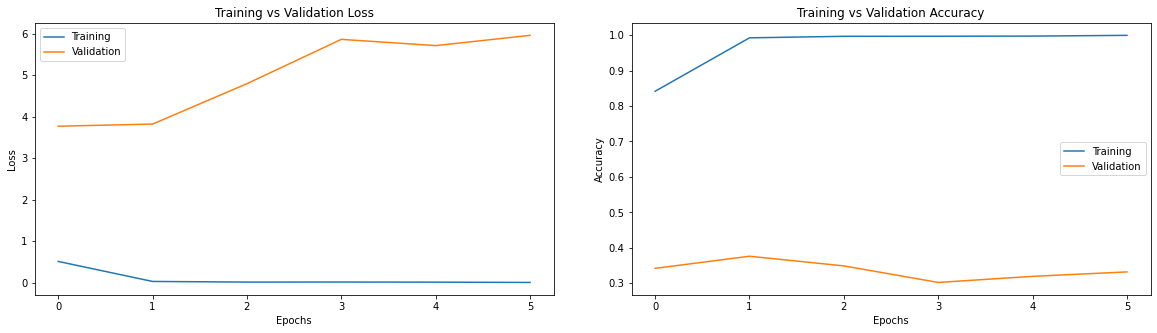

In [ ]:
model_eval(cnn, history)

------------------------------------------------------------------------------------------------------------------------------------------------

# Validation Dataset Evaluation

## Classification Report and Confusion Matrix

In [307]:
def val_preds(cnn, train_images, x_val):
    pred = cnn.predict(val_images, verbose=1)
    pred = np.argmax(pred, axis=1)
    labels = train_images.class_indices
    labels = dict((v,k) for k, v in labels.items())
    y_pred = [labels[k] for k in pred]
    
    print(classification_report(x_val['classname'], y_pred))
    
    cf_matrix = confusion_matrix(x_val['classname'], y_pred)

    fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,10))

    sns.heatmap(cf_matrix, annot=True, fmt='d', square=False, linewidths=.5, 
                vmin=250, vmax=375, cmap='OrRd', ax=ax1);
    ax1.set_xlabel('Predicted Value')
    ax1.set_ylabel('True Value')
    ax1.set_xticklabels(train_images.class_indices)
    ax1.set_yticklabels(train_images.class_indices)
    ax1.set_title('Confusion Matrix')

    celltext = [f'{k} : {v}' for k, v in class_labels_dict.items()]
    # print(celltext)

    # Adjust layout to make room for the table:
    # plt.subplots_adjust(left=0.2, bottom=0.3)

    the_table = ax2.table(cellText=np.asarray(celltext).reshape(5,2).T,
                          # rowLabels=np.asarray(list(class_labels_dict.keys())).T,
                          # rowLabels=['Labels'],
                          # rowColours=colors,
                          # colLabels=['Description'],
                          # colWidths=[0.25],
                          loc='bottom',
                          cellLoc='center'
                         )

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    the_table.scale(1, 2)


    ax2.axis('off')

    bbox1 = ax1.get_position()
    bbox2 = ax2.get_position()

    # modify as needed
    left = bbox1.x0
    bottom = bbox1.y0 - (bbox2.height * 0.2)
    width = bbox1.x0 + (bbox1.width * 1.0)
    height = bbox2.height

    ax2.set_position([left, bottom, width, height])
    fig.set_dpi(100)
    
    # pred_df = pd.DataFrame(data=cnn.predict(val_images), columns=val_images.class_indices, index=(val_images.filenames))
    # pred_df.index = pred_df.index.map(os.path.basename)



In [308]:
best_model_file = 'best_model_vgg16_dropout_1024.hdf5'

best_model = tf.keras.models.load_model(os.path.join(model_dir, best_model_file))

140/140 [==============================] - 466s 3s/step
              precision    recall  f1-score   support

          c0       0.69      0.84      0.75       481
          c1       0.97      0.60      0.74       452
          c2       0.52      0.57      0.54       469
          c3       0.98      0.72      0.83       476
          c4       0.72      0.83      0.77       476
          c5       0.78      0.77      0.78       456
          c6       0.60      0.79      0.69       453
          c7       0.85      0.87      0.86       413
          c8       0.99      0.22      0.36       398
          c9       0.40      0.64      0.49       400

    accuracy                           0.69      4474
   macro avg       0.75      0.68      0.68      4474
weighted avg       0.75      0.69      0.69      4474



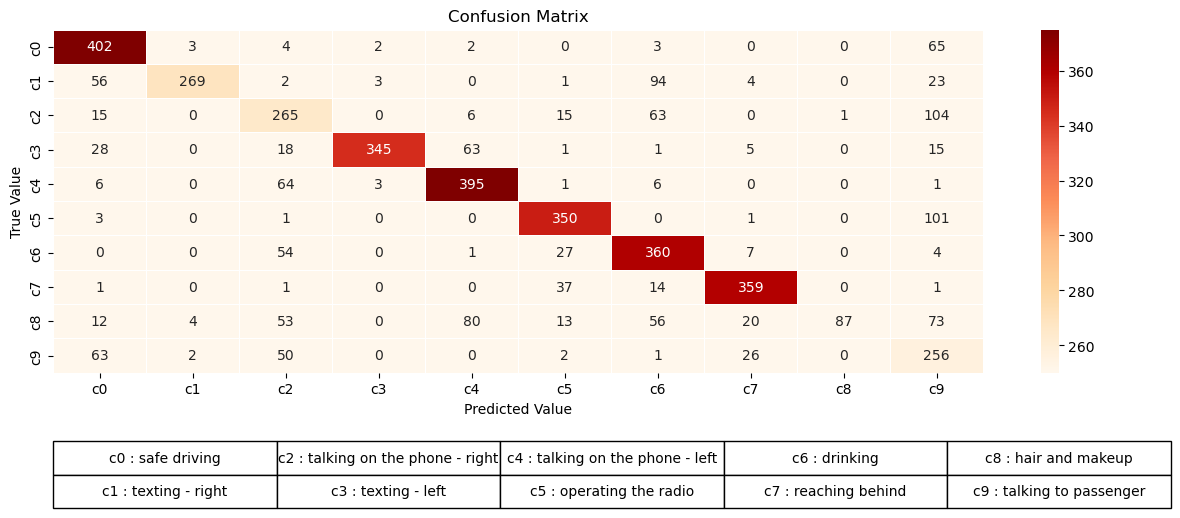

In [309]:
val_preds(best_model, train_images, x_val)

## Mislabeled Predictions Analysis

In [304]:
# https://learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
# Utility function for obtaining of the errors 
def obtain_errors(val_images, predictions):
    # Get the filenames from the generator
    fnames = val_images.filenames

    # Get the ground truth from generator
    ground_truth = val_images.classes

    # Get the dictionary of classes
    label2index = val_images.class_indices

    # Obtain the list of the classes
    idx2label = list(label2index.keys())
    print("The list of classes: ", idx2label)

    # Get the class index
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("Number of errors = {}/{}".format(len(errors),val_images.samples))
    
    return idx2label, errors, fnames


# Utility function for visualization of the errors
def show_errors(idx2label, errors, predictions, fnames):
    
    fig = plt.figure(figsize=(30,20))
    random.seed(42)
    # Show the errors
    idx_show_images = random.sample(range(len(errors)), 20) #generate a random list of numbers to use as index to show mislabelled predictions
    ncols = 5
    nrows = len(idx_show_images)/ncols
    for idx, i in enumerate(idx_show_images):
        
        ax = fig.add_subplot(nrows,ncols,idx+1)
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]
        
        title = f"Original label: {class_labels_dict[fnames[errors[i]].split('/')[-2]]}\n \
        Prediction :{class_labels_dict[pred_label]}\n \
        confidence :{predictions[errors[i]][pred_class]:0.3f}"
        
        ax.imshow(plt.imread(fnames[errors[i]]))
        ax.set_title(title, color='palevioletred')
        ax.axis('off')
    

    fig.suptitle(f'Mislabeled Predictions', color='palevioletred', fontsize = 18)
    plt.gcf().subplots_adjust(hspace=0.01, wspace=0.05, top=0.95)

        # original = load_img('{}'.format(fnames[errors[i]]))
        # plt.figure(figsize=[7,7])
        # plt.axis('off')
        # plt.title(title)
        # plt.imshow(original)
        # plt.show()

In [229]:
# Get the predictions from the model using the generator
predictions = best_model.predict(val_images, verbose=1)



140/140 [==============================] - 444s 3s/step


In [305]:
# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(val_images, predictions)


The list of classes:  ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Number of errors = 1386/4474


/var/folders/vc/262dx0q508d6dv26phhy52ph0000gn/T/ipykernel_79270/4214670719.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(nrows,ncols,idx+1)


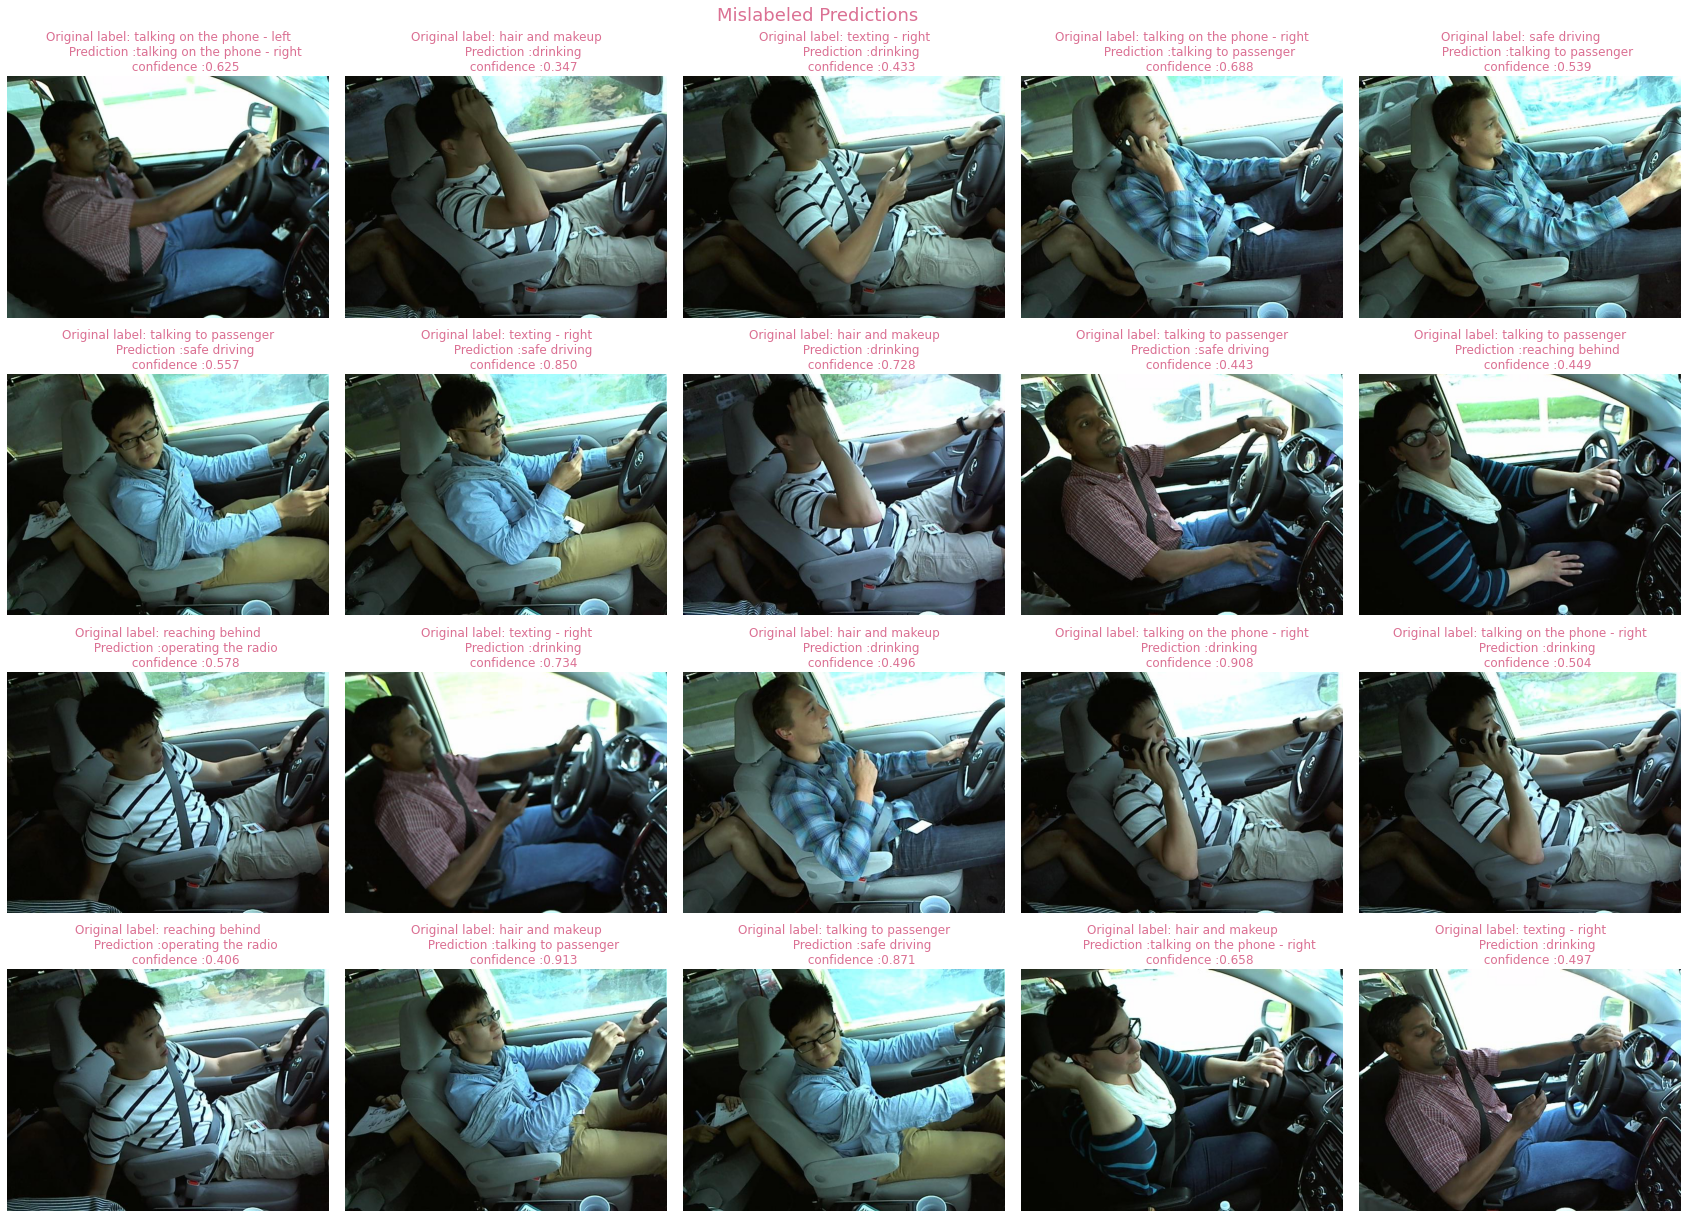

In [306]:

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames)

------------------------------------------------------------------------------------------------------------------------------------------------

# Kaggle Submissions

**This code only prepares a Kaggle output file for a single model. If interested in generating kaggle outputs for all the models and also directly submitting them from the notebook refer to kaggle_testing_dataset notebook**

In [ ]:
def kaggle_submission(test_images, train_images, cnn):
    pred = cnn.predict(test_images)
    pred_df = pd.DataFrame(data=pred, columns=train_images.class_indices, index=(test_images.filenames))
    pred_df.index = pred_df.index.map(os.path.basename)
    pred_df.index.name='img'
    pred_df.to_csv('../submissions/basemodel.csv')

In [ ]:
test_images.reset()

In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col=None,
    target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    class_mode=None,
    batch_size=32,
    shuffle=False
)

Found 79726 validated image filenames.


In [ ]:
kaggle_submission(test_images, train_images, cnn)